## Representación de baja dimension + Clustering

In [1]:
from src import metrics
from src import plots
from src import preprocessing
from src import models

import numpy as np
import pandas as pd


Preparar X para representación (ya con FE_v2)

In [2]:
import pandas as pd
import numpy as np
from src import preprocessing  # add_basic_features

# Cargar datos combinados
df = pd.read_csv("data/processed/monaco_2025_colapinto_alllaps.csv")

# Filtrar pista verde
if "TrackStatus" in df.columns:
    df = df[df["TrackStatus"] == 1].copy()

# Asegurar LapTime_s
if "LapTime_s" not in df.columns:
    df["LapTime"] = pd.to_timedelta(df["LapTime"])
    df["LapTime_s"] = df["LapTime"].dt.total_seconds()

# Aplicar FE_v2
df_fe2 = preprocessing.add_basic_features(df)

# Sacar Position si aparece
if "Position" in df_fe2.columns:
    df_fe2 = df_fe2.drop(columns=["Position"])

# Definir features numéricas y categóricas (FE_v2)
LEGAL_FEATURES_NUM_V2 = [
    "LapNumber",
    "Stint",
    "TyreLife",
    "lap_norm_session",
    "is_race",
    "compound_order",
]

LEGAL_FEATURES_CAT = [
    "Session",
    "Compound",
]

LEGAL_FEATURES_NUM_V2 = [c for c in LEGAL_FEATURES_NUM_V2 if c in df_fe2.columns]
LEGAL_FEATURES_CAT     = [c for c in LEGAL_FEATURES_CAT     if c in df_fe2.columns]

FEATURES_V2 = LEGAL_FEATURES_NUM_V2 + LEGAL_FEATURES_CAT

X = df_fe2[FEATURES_V2].copy()
y = df_fe2["LapTime_s"].to_numpy()  # por si después querés mirar algo supervisado


## PCA sobre el espacio preprocesado:

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Preprocesador para representación
rep_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), LEGAL_FEATURES_NUM_V2),
        ("cat", OneHotEncoder(handle_unknown="ignore"), LEGAL_FEATURES_CAT),
    ]
)

# Pipeline: preprocesado + PCA
pca_dim = 2  # podés probar 3 más adelante para análisis más fino

rep_pipeline = Pipeline(steps=[
    ("preprocess", rep_preprocessor),
    ("pca", PCA(n_components=pca_dim, random_state=42)),
])

Z_pca = rep_pipeline.fit_transform(X)  # Z_pca tiene shape (n_vueltas, 2)

pca = rep_pipeline.named_steps["pca"]
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza explicada acumulada:", pca.explained_variance_ratio_.sum())


Varianza explicada por cada componente: [0.46406185 0.28027959]
Varianza explicada acumulada: 0.7443414428721264


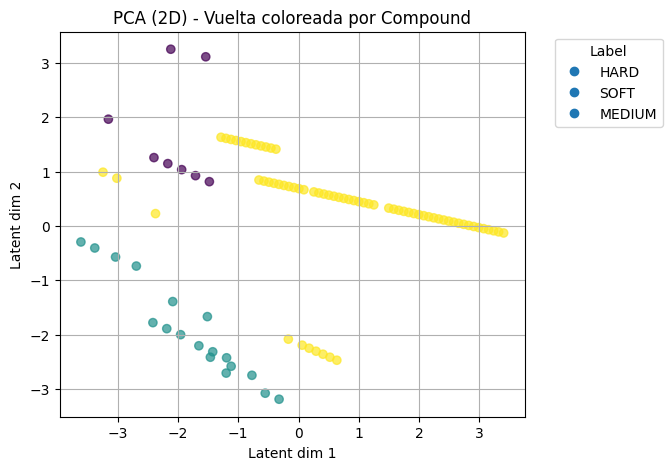

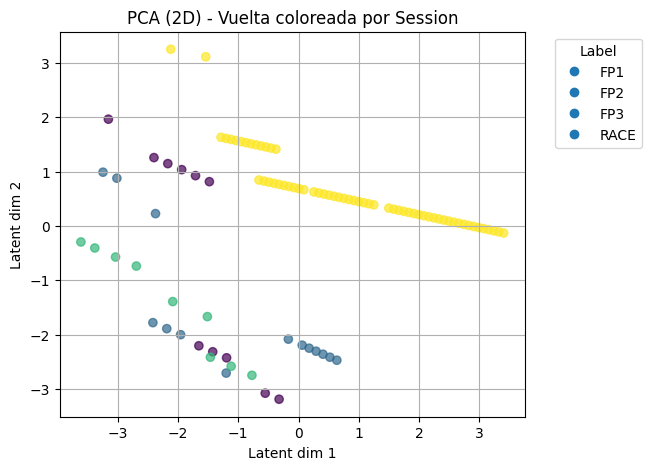

In [4]:
from src import plots
import matplotlib.pyplot as plt

# Coloreado por compuesto
plots.latent_scatter(
    Z_pca,
    labels=df_fe2["Compound"],
    title="PCA (2D) - Vuelta coloreada por Compound"
)

# Coloreado por sesión (FP1/FP2/FP3/RACE)
plots.latent_scatter(
    Z_pca,
    labels=df_fe2["Session"],
    title="PCA (2D) - Vuelta coloreada por Session"
)


## Clustering en el espacio latente (k-means)

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = {}
for K in range(2, 8):
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(Z_pca)
    score = silhouette_score(Z_pca, labels_k)
    sil_scores[K] = score
    print(f"K={K}: silhouette={score:.3f}")


K=2: silhouette=0.401
K=3: silhouette=0.548
K=4: silhouette=0.536
K=5: silhouette=0.514
K=6: silhouette=0.508
K=7: silhouette=0.506


In [6]:
K_opt = max(sil_scores, key=sil_scores.get)
print("K óptimo (según silhouette):", K_opt)

kmeans = KMeans(n_clusters=K_opt, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(Z_pca)


K óptimo (según silhouette): 3


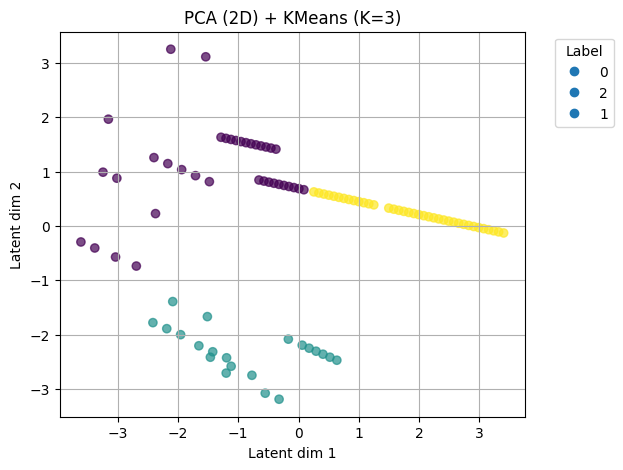

In [7]:
plots.latent_scatter(
    Z_pca,
    labels=cluster_labels,
    title=f"PCA (2D) + KMeans (K={K_opt})"
)


In [8]:
from src.metrics import cluster_purity

purity_compound = cluster_purity(df_fe2["Compound"], cluster_labels)
purity_session  = cluster_purity(df_fe2["Session"], cluster_labels)

print(f"Pureza respecto a Compound: {purity_compound:.3f}")
print(f"Pureza respecto a Session : {purity_session:.3f}")


Pureza respecto a Compound: 0.800
Pureza respecto a Session : 0.758
